# Data Visualization

This notebook will showcase most of the visuals created during the project's data exploration and explanation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

import plotly.graph_objs as go
import plotly.express as px
import plotly.offline as pyo

from sklearn.feature_extraction.text import CountVectorizer 

import nltk
from nltk.corpus import stopwords

from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
from nlp_functions import text_feature_engineering, pos_lemmatizer

In [3]:
fomc = pd.read_pickle('../data/fomc_data.pkl')
fomc.head(3)

minutes_paragraphs  \
1993-02-03  [[meeting, federal, open, market, committee, h...   
1993-03-23  [[meeting, federal, open, market, committee, h...   
1993-05-18  [[meeting, federal, open, market, committee, h...   

                                            paragraphs_length  \
1993-02-03  [12, 15, 24, 29, 12, 32, 37, 32, 14, 16, 82, 5...   
1993-03-23  [11, 13, 64, 23, 24, 28, 60, 51, 64, 56, 100, ...   
1993-05-18  [11, 26, 19, 25, 27, 62, 46, 54, 37, 89, 56, 6...   

                                                 minutes_text text_length  
1993-02-03  meeting federal open market committee hold off...        4437  
1993-03-23  meeting federal open market committee hold off...        2789  
1993-05-18  meeting federal open market committee hold off...        2354

In [4]:
# setting up the corpus for the word cloud
fomcwordcloud = [word for minute in fomc['minutes_paragraphs'] for val in minute for word in val]

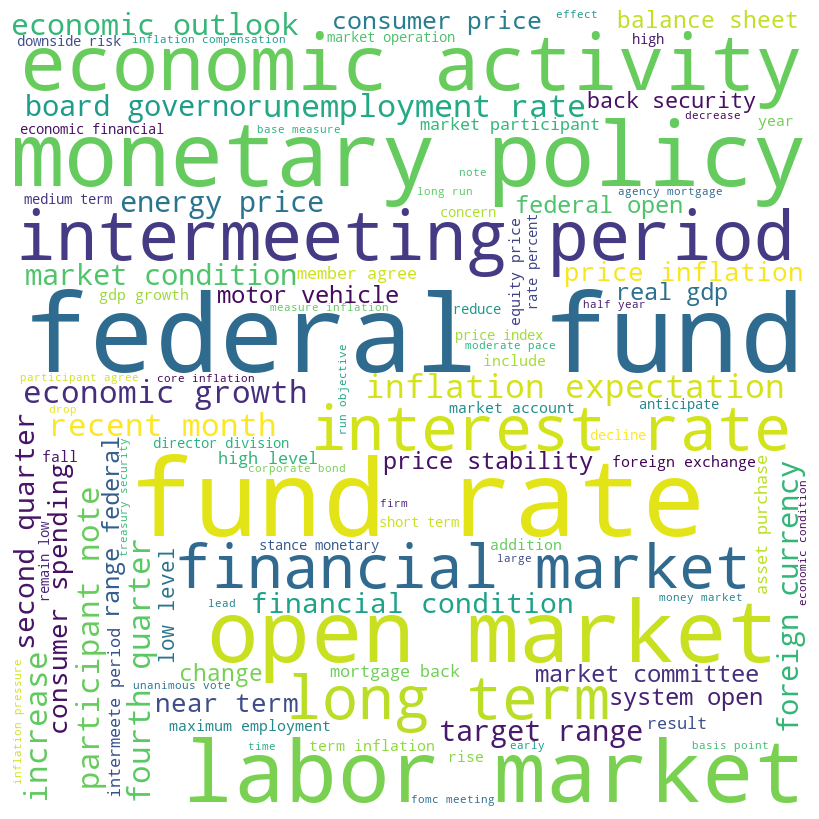

In [5]:
# source: https://www.analyticsvidhya.com/blog/2021/05/how-to-build-word-cloud-in-python/

plt.figure(figsize=(8,8))
wordcloud = WordCloud(
    background_color="white", 
    colormap="viridis",  
    width=800, height=800,  
    max_words=100, 
    contour_color='steelblue', 
    contour_width=3,  

).generate(','.join(fomcwordcloud))
plt.imshow(wordcloud, interpolation='bilinear');
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('../images/wordcloud_bigrams.png', dpi=600);

In [6]:
fomc_raw = pd.read_pickle('../data/fomc_raw_text.pkl')
fomc_raw.head()

fomc_text
date                                                         
1993-02-03  The Secretary reported that advices of the ele...
1993-03-23  At the start of the meeting, the subcommittee ...
1993-05-18  1. Attended portion of meeting relating to a r...
1993-07-07  Mr. Kohn, Secretary and Economist Mr. Bernard,...
1993-08-17  Secretary's Note: Advice had been received of ...

In [7]:
fomc_raw = text_feature_engineering(fomc_raw, 'fomc_text') 
fomc_raw.head(3)

fomc_text  char_length  \
date                                                                         
1993-02-03  The Secretary reported that advices of the ele...        54931   
1993-03-23  At the start of the meeting, the subcommittee ...        34755   
1993-05-18  1. Attended portion of meeting relating to a r...        29564   

            word_count  mean_word_length  count_sentence  \
date                                                       
1993-02-03        8546          5.427802             246   
1993-03-23        5242          5.630294             177   
1993-05-18        4461          5.627438             159   

            mean_word_per_sentence  mean_char_per_sentence  
date                                                        
1993-02-03               34.739837              222.300813  
1993-03-23               29.615819              195.361582  
1993-05-18               28.056604              184.943396

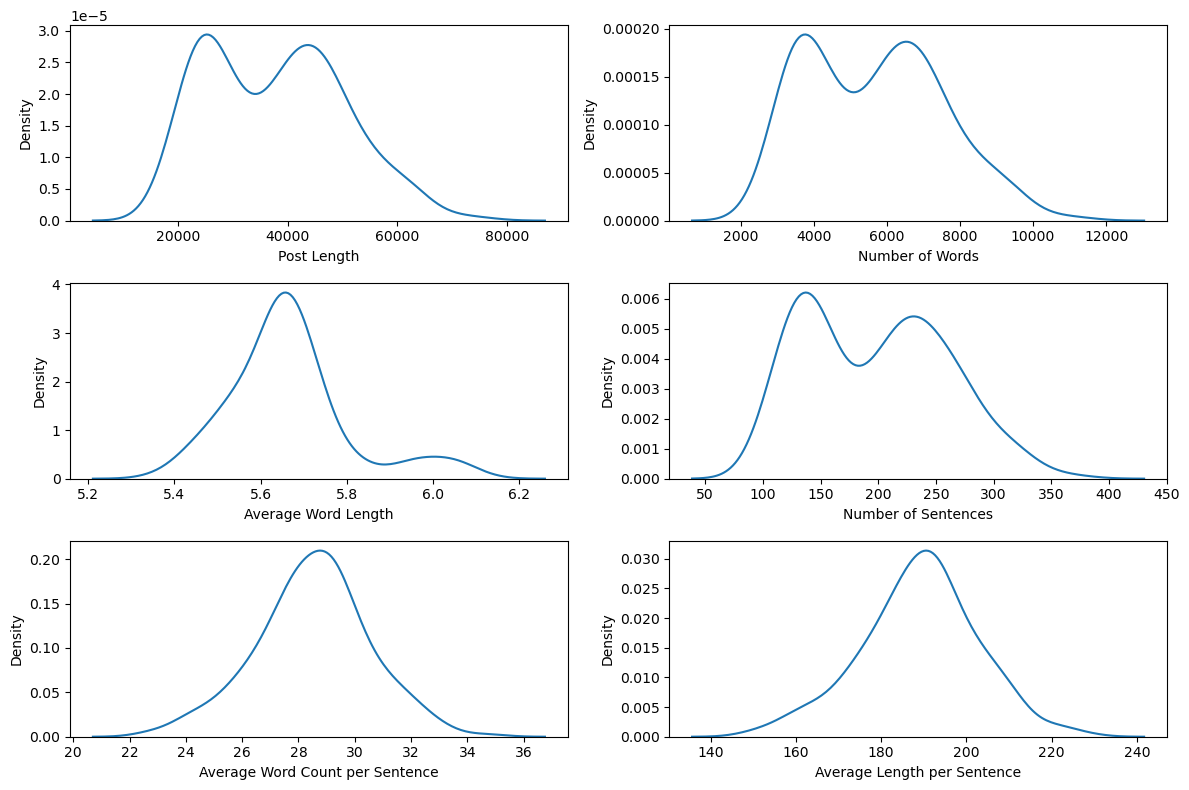

In [8]:
fig, ax = plt.subplots(3, 2, figsize=(12,8))

sns.kdeplot(fomc_raw, x='char_length', ax=ax[0, 0])
ax[0, 0].set_xlabel('Post Length')

sns.kdeplot(fomc_raw, x='word_count', ax=ax[0, 1])
ax[0, 1].set_xlabel('Number of Words')

sns.kdeplot(fomc_raw, x='mean_word_length', ax=ax[1, 0])
ax[1, 0].set_xlabel('Average Word Length')


sns.kdeplot(fomc_raw, x='count_sentence', ax=ax[1, 1])
ax[1, 1].set_xlabel('Number of Sentences')

sns.kdeplot(fomc_raw, x='mean_word_per_sentence', ax=ax[2, 0])
ax[2, 0].set_xlabel('Average Word Count per Sentence')

sns.kdeplot(fomc_raw, x='mean_char_per_sentence', ax=ax[2, 1])
ax[2, 1].set_xlabel('Average Length per Sentence')

plt.tight_layout()

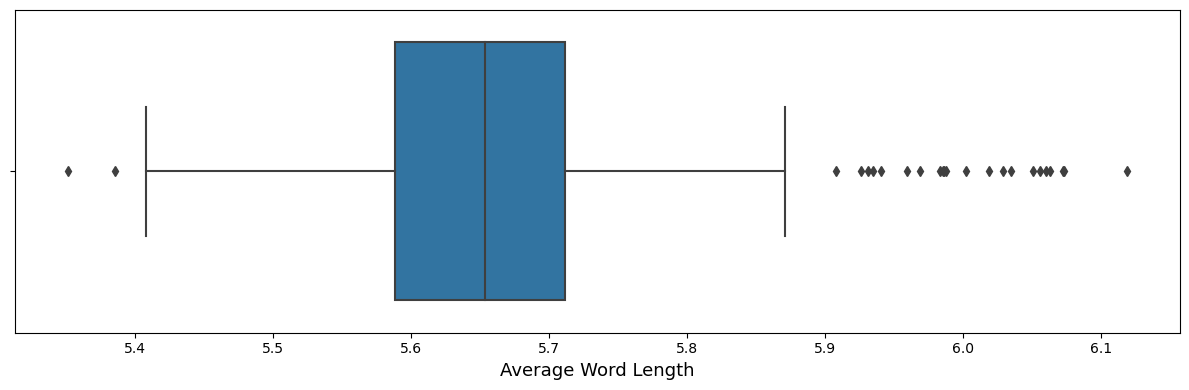

In [9]:
plt.figure(figsize=(12, 4))
sns.boxplot(fomc_raw, x='mean_word_length')

plt.xlabel('Average Word Length', fontdict={'fontsize': 13})
plt.tight_layout()

## Term Frequency Analysis

Term frequency analysis is a valuable tool in natural language processing (NLP) as it provides insights into the significance and relevance of words within a given document. By calculating the frequency of each term in a text, we can identify the most commonly used words, which often reflect the main themes and topics. 

In [10]:
#removing some of the frequent yet redundant words
custom_words = ['would', 'committee', 'participant'] 
stop_words = set(stopwords.words('english'))
stop_words.update(custom_words)

In [11]:
# Count the occurrences of each word in the 'fomcwordcloud' collection and store as word-frequency pairs.
bow = Counter(fomcwordcloud).items()

# Filter out stop words from the word-frequency pairs and create a new dictionary.
bow = {word: count for word, count in bow if word not in list(stop_words)}

# Convert the filtered word-frequency dictionary into a pandas DataFrame.
bow = pd.DataFrame(bow.items(), columns=['word', 'frequency'])

bow.sort_values('frequency', ascending=False, inplace=True)
bow.head(5)

word  frequency
3       market      12020
149       rate      11320
401  inflation      10569
363   economic       8500
128      price       8483

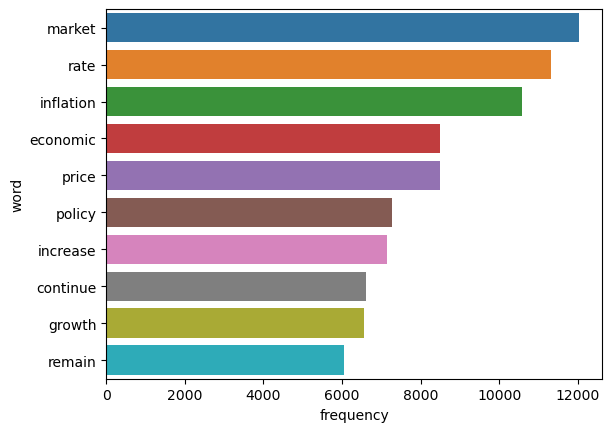

In [12]:
sns.barplot(bow.head(10), y = 'word', x='frequency');

As you can see, some commonly used words in the data include "market," "rate," "inflation," and more. This is quite logical and expected.

##  Most Common Words

Besides analyzing word frequency, it's important to explore the words that appear most often in FOMC meetings. This gives us a broader view of the discussed topics. For this analysis, we use Scikit-learn's CountVectorizer from the feature extraction module. 

In [13]:
# custom_words = ['would', 'committee', 'participants']
# stop_words = set(stopwords.words('english'))
# stop_words.update(custom_words)

In [14]:
lemmatized_text = fomc_raw['fomc_text'].apply(pos_lemmatizer)

In [15]:
# note that stop_words were updated earlier in the notebook.
cvec = CountVectorizer(stop_words=list(stop_words)) 
X = cvec.fit_transform(lemmatized_text)
df = pd.DataFrame(X.todense(), columns=cvec.get_feature_names_out())

common_words_unigrams = df.sum().sort_values(ascending=False).head(10)

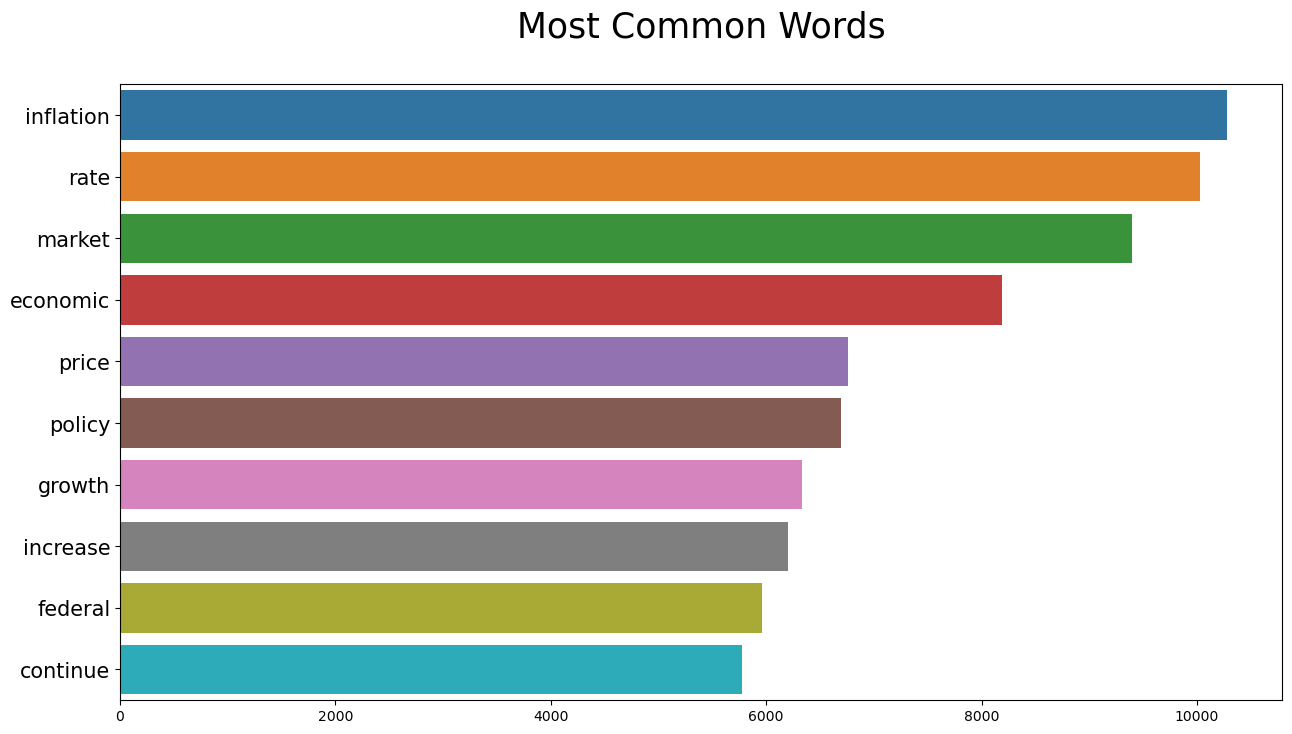

In [16]:
plt.figure(figsize=(15, 8))
sns.barplot(y = common_words_unigrams.index, x= common_words_unigrams)
plt.title('Most Common Words\n', fontsize=25)
plt.yticks(fontsize=15)


plt.savefig('../images/most_common_words.png', dpi=1200);

The word "inflation" comes up most often in the meetings, followed by "rate," "market," and "economic."

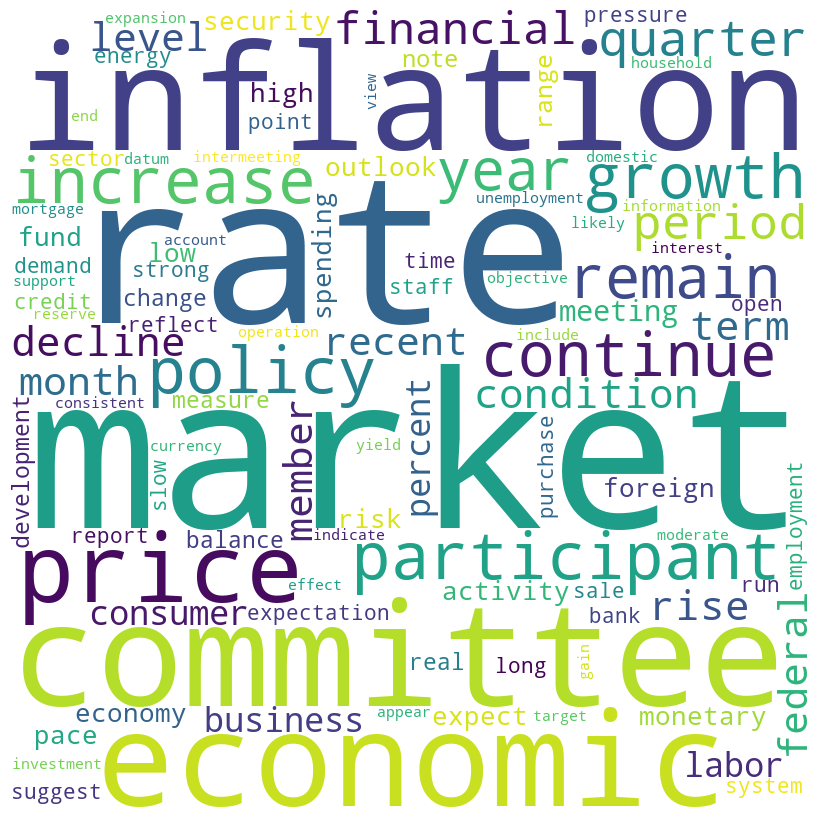

In [17]:
plt.figure(figsize=(8,8))
wordcloud = WordCloud(
    background_color="white", 
    colormap="viridis",  
    width=800, height=800,  
    max_words=100,  
    contour_color='steelblue',  
    contour_width=3,
    collocations=False,

    
).generate(','.join(fomcwordcloud)) 
plt.imshow(wordcloud, interpolation='bilinear');
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('../images/wordcloud_unigram.png', dpi=600)

### Most Common Word Pairs

Next, I looked for the most common pairs of words used in the meetings. The results were fascinating and added more insight to the data.

In [18]:
cvec = CountVectorizer(stop_words=list(stop_words), ngram_range=(2,2))
X = cvec.fit_transform(lemmatized_text)
df = pd.DataFrame(X.todense(), columns=cvec.get_feature_names_out())

common_words_bigrams = df.sum().sort_values(ascending=False).head(10)

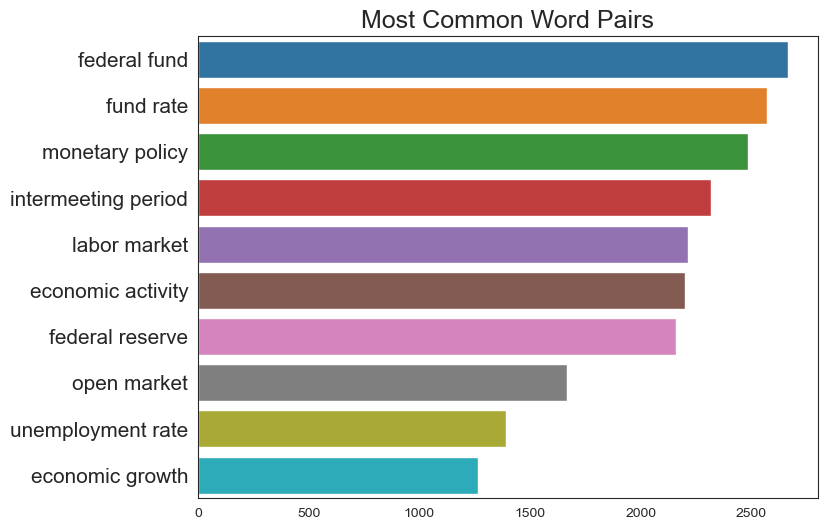

In [81]:
plt.figure(figsize=(8, 6))
sns.barplot(y = common_words_bigrams.index, x= common_words_bigrams)

plt.title('Most Common Word Pairs', fontsize=18)
plt.yticks(fontsize=15);

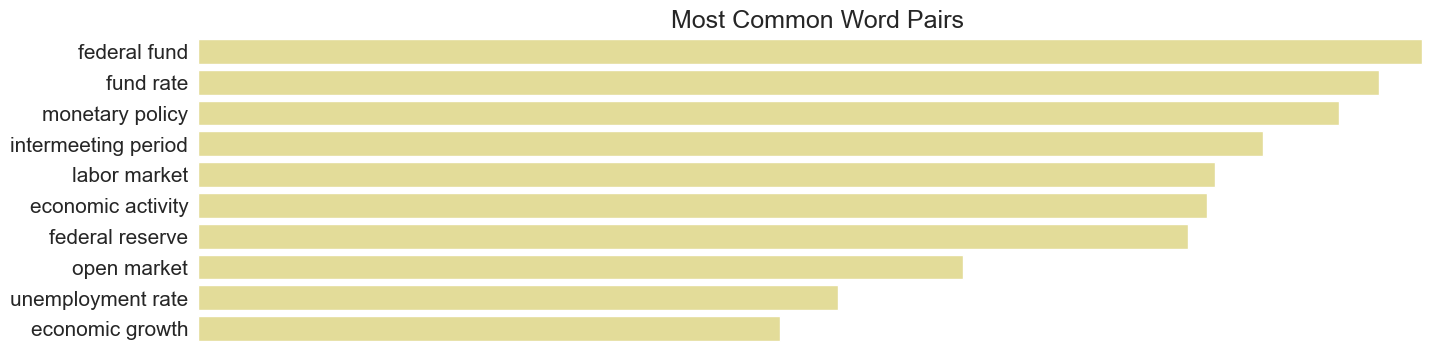

In [96]:
plt.figure(figsize=(16, 4))
sns.barplot(y=common_words_bigrams.index, x=common_words_bigrams, color='khaki')

plt.title('Most Common Word Pairs', fontsize=18)
plt.yticks(fontsize=15)
plt.xlim(0, 2700)
plt.xticks(ticks=[], labels=[])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.savefig('../images/most_common_bigrams.png', dpi=600);


## Stock Market

In [20]:
data = pd.read_pickle('../data/full_data.pkl')

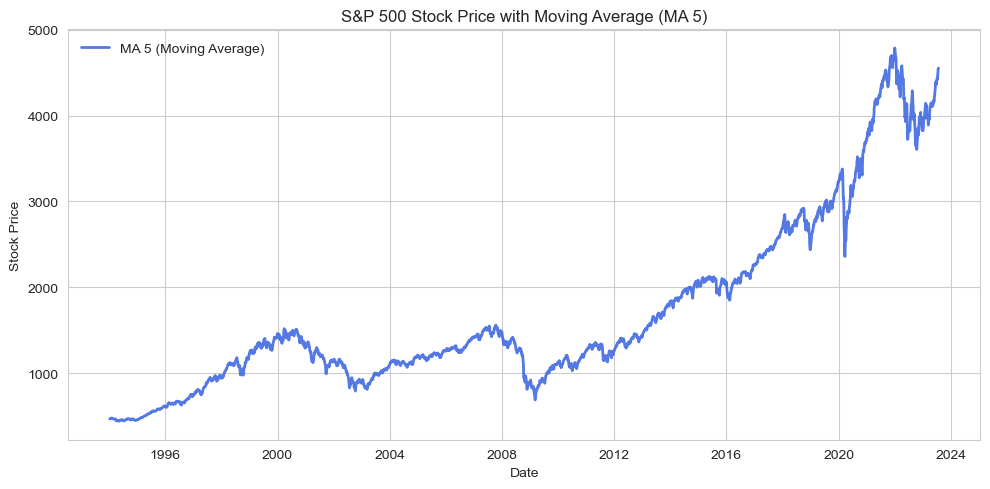

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 5))
sns.set_style('whitegrid') 

# plt.plot(data.index, data['Adj Close'], alpha=0.4, ls='dotted', c='black', label='Stock Price', linewidth=1)
plt.plot(data.index, data['Adj Close'].rolling(5).mean(), alpha=0.9, label='MA 5 (Moving Average)', c='royalblue', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('S&P 500 Stock Price with Moving Average (MA 5)')

plt.legend(loc='upper left', frameon=False)

plt.tight_layout()
plt.savefig('../images/sp500.png', dpi=600);

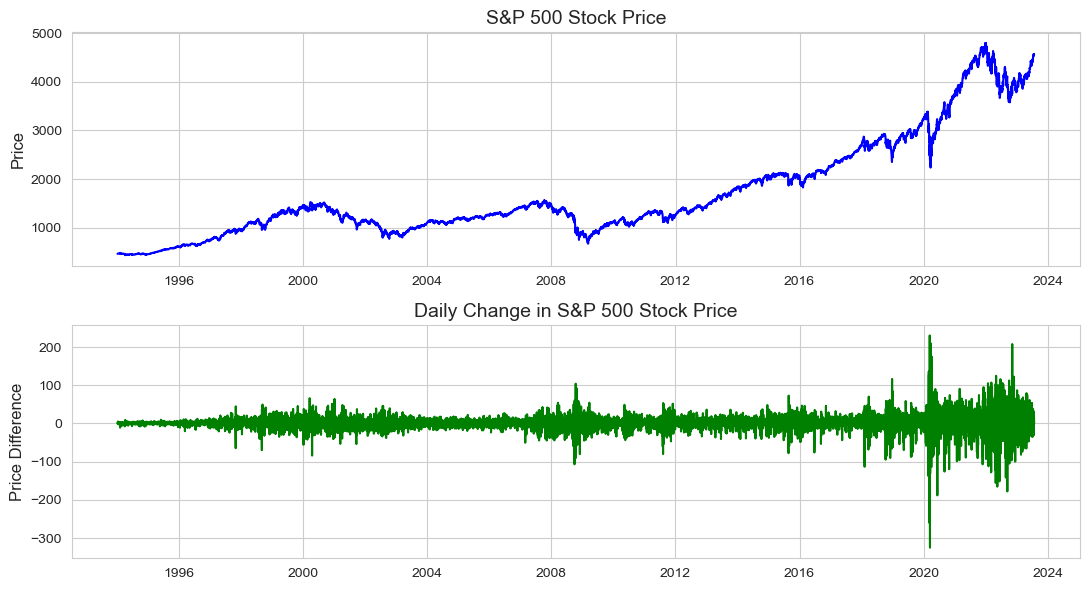

In [22]:
fig, ax = plt.subplots(2, figsize=(11, 6))
# Plotting 'Adj Close' data on the first subplot
ax[0].plot(data['Adj Close'], color='blue')
ax[0].set_title('S&P 500 Stock Price', fontsize=14)
ax[0].set_ylabel('Price', fontsize=12)

# Plotting the difference of 'Adj Close' data on the second subplot
ax[1].plot(data['Adj Close'].diff(), color='green')
ax[1].set_title('Daily Change in S&P 500 Stock Price', fontsize=14)
ax[1].set_ylabel('Price Difference', fontsize=12)
plt.tight_layout()

plt.savefig('../images/sp500_diff.png', dpi=600);

In [23]:
def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    plt.figure(figsize=(18,9))
    
    for col in cols:
            
        plt.plot(df[col])
        
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

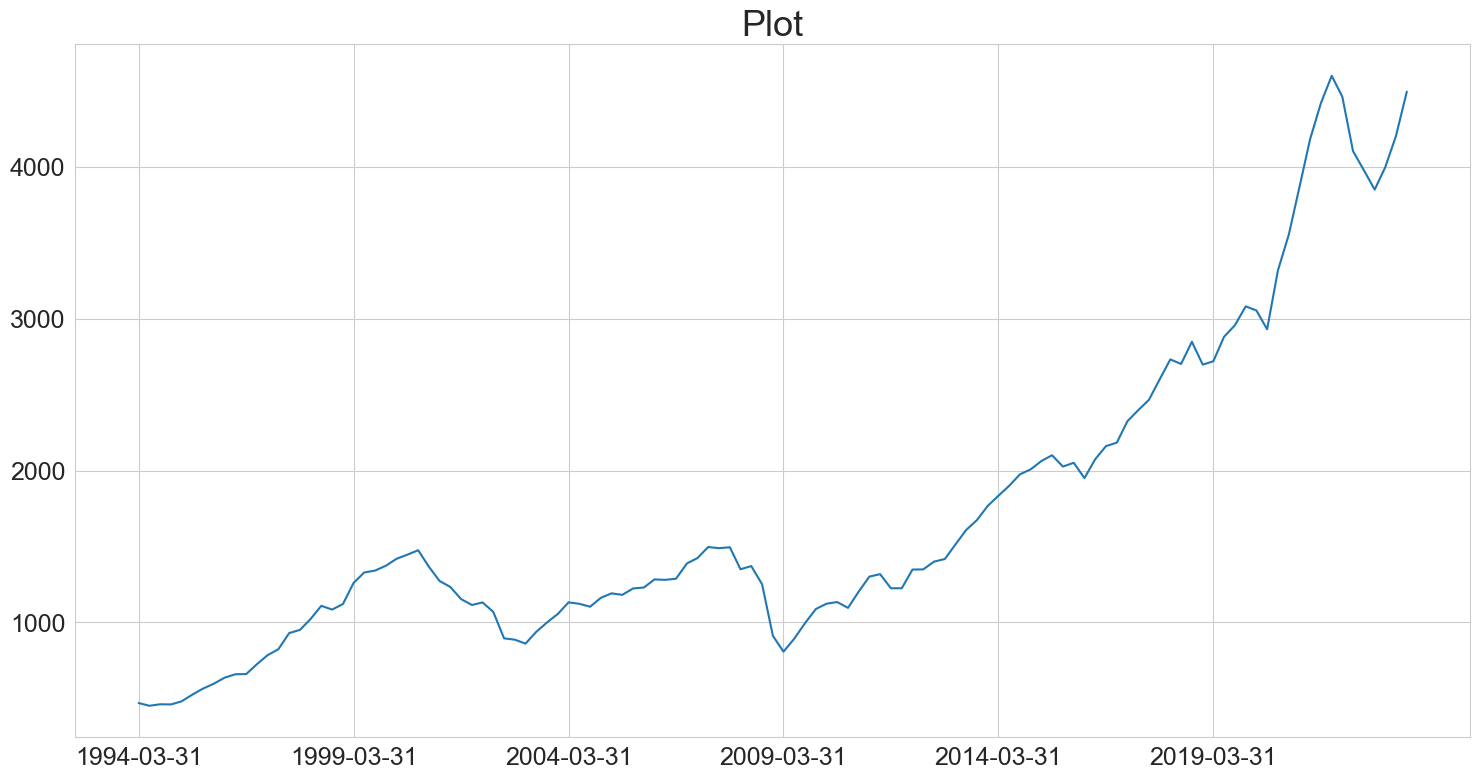

In [24]:
plot_series(data.resample('Q').mean(), cols=['Adj Close'], title='Plot', steps=20)

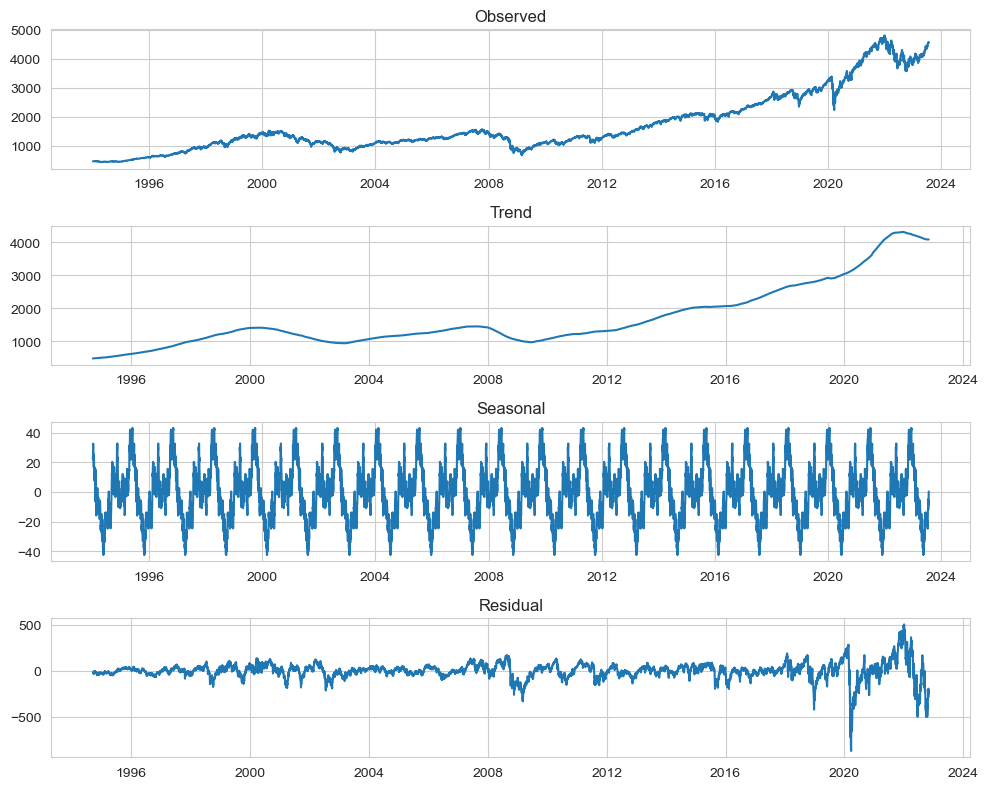

In [25]:
decomp = seasonal_decompose(data['Adj Close'], period=365)

plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(decomp.observed)
plt.title('Observed')

plt.subplot(4, 1, 2)
plt.plot(decomp.trend)
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(decomp.seasonal)
plt.title('Seasonal')

plt.subplot(4, 1, 4)
plt.plot(decomp.resid)
plt.title('Residual')

plt.tight_layout()
plt.show()

/Users/sdastan/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



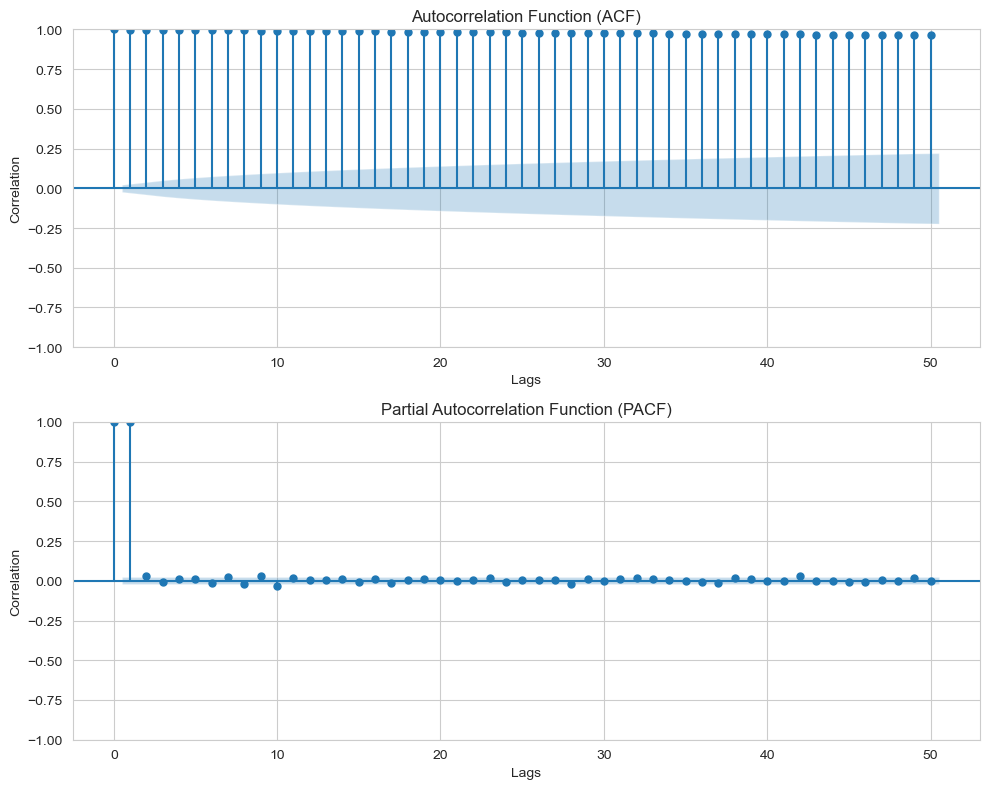

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot ACF
plot_acf(data['Adj Close'], lags=50, ax=ax1, alpha=0.05)
ax1.set_title('Autocorrelation Function (ACF)')
ax1.set_xlabel('Lags')
ax1.set_ylabel('Correlation')
ax1.grid(True)

# Plot PACF
plot_pacf(data['Adj Close'], lags=50, ax=ax2, alpha=0.05)
ax2.set_title('Partial Autocorrelation Function (PACF)')
ax2.set_xlabel('Lags')
ax2.set_ylabel('Correlation')
ax2.grid(True)

plt.tight_layout()
plt.show()

### FRED data (economic indicators)

In [27]:
fred = pd.read_pickle('../data/fred.pkl')

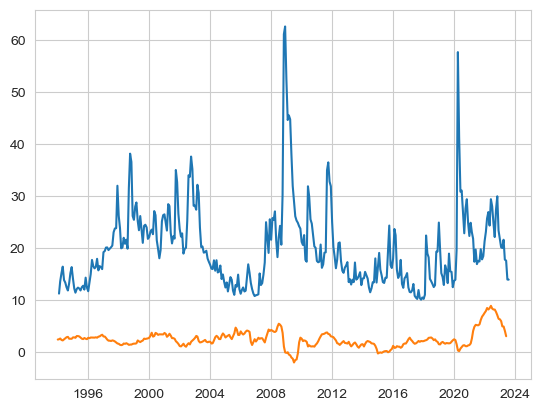

In [28]:
plt.plot(data['vix'].resample('M').mean())
plt.plot(fred['inflation_yoy'].dropna())

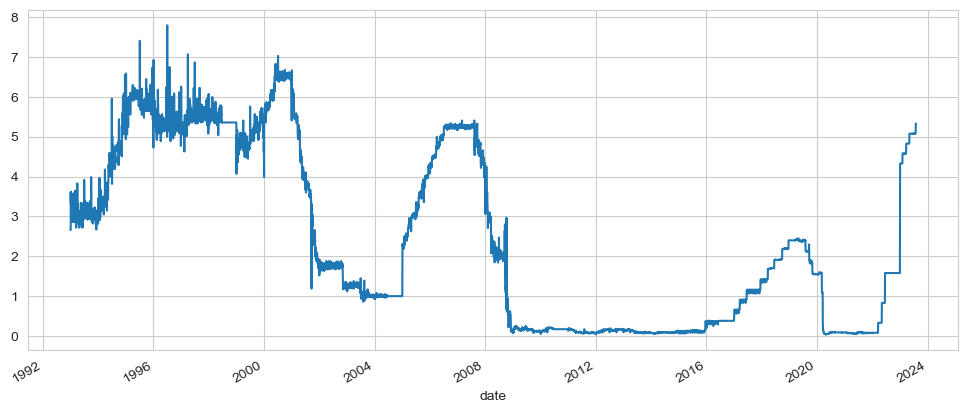

In [29]:
plt.figure(figsize=(12, 5))
fred['ffr'].ffill().plot();

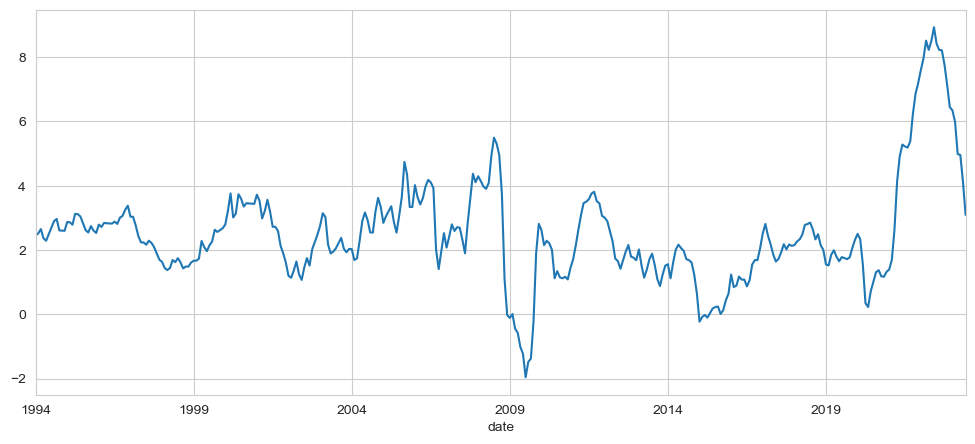

In [30]:
plt.figure(figsize=(12, 5))
fred['inflation_yoy'].dropna().plot();

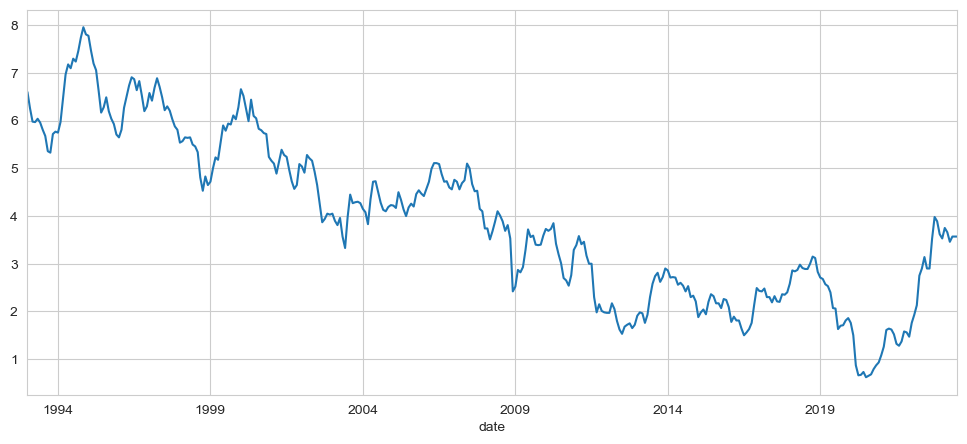

In [31]:
plt.figure(figsize=(12, 5))
fred['10_year_treasury_yeild'].ffill().resample('M').mean().plot();

In [32]:
# Recessionary periods over the past 3 decades.
#2001
date_range01_start = datetime.strptime('2001-03-01', '%Y-%m-%d')
date_range01_end = datetime.strptime('2001-10-30', '%Y-%m-%d')

#2007
date_range07_start = datetime.strptime('2007-04-01', '%Y-%m-%d')
date_range07_end = datetime.strptime('2009-05-30', '%Y-%m-%d')

#2020
date_range20_start = datetime.strptime('2020-02-01', '%Y-%m-%d')
date_range20_end = datetime.strptime('2020-03-30', '%Y-%m-%d')

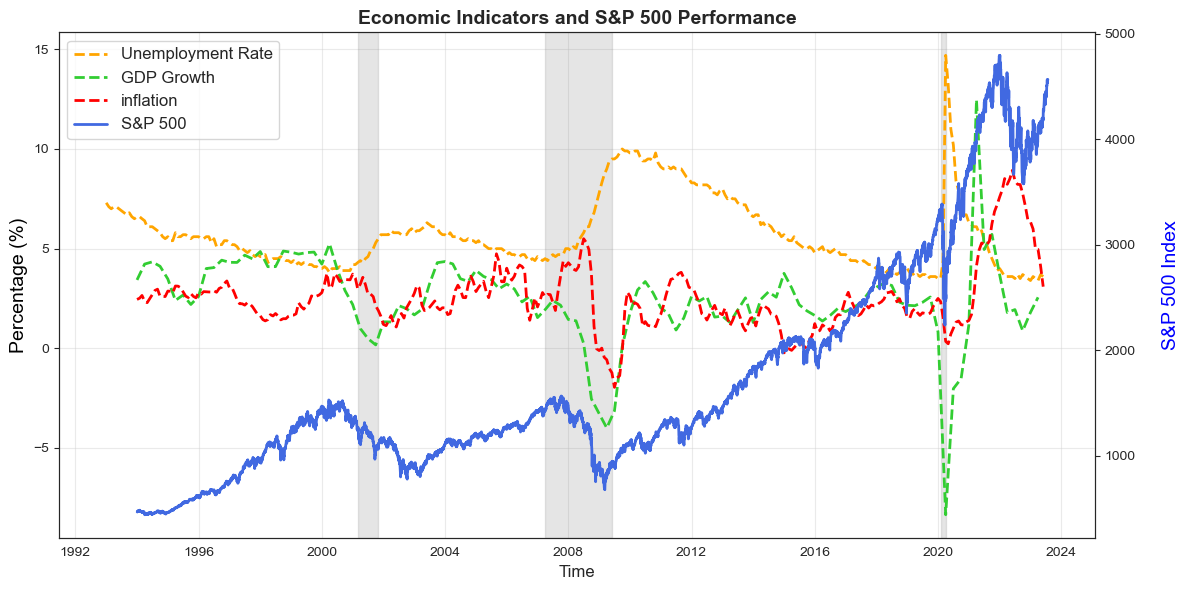

In [33]:
sns.set_style('white')

fig, ax0 = plt.subplots(figsize=(12, 6))
ax1 = ax0.twinx()

ax0.plot(fred['unemployment_rate'].dropna(), color='orange', label='Unemployment Rate', linestyle='dashed', linewidth=2)
ax0.plot(fred['gdp_growth_yoy'].dropna(), color='limegreen', label='GDP Growth', linestyle='--', linewidth=2)
ax0.plot(fred['inflation_yoy'].dropna(), color='red', label='inflation', linestyle='--', linewidth=2)

ax1.plot(data['Adj Close'], color='royalblue', label='S&P 500', linewidth=2)

ax0.set_xlabel('Time', fontsize=12)
ax0.set_ylabel('Percentage (%)', color='black', fontsize=14)
ax1.set_ylabel('\nS&P 500 Index', color='b', fontsize=14)

lines, labels = ax0.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=12)

ax0.grid(alpha=0.4)

# https://stackoverflow.com/questions/23248435/fill-between-two-vertical-lines-in-matplotlib
ax0.axvspan(date_range01_start, 
            date_range01_end, alpha=0.2, color='grey')

ax0.axvspan(date_range07_start, 
            date_range07_end, alpha=0.2, color='grey')

ax0.axvspan(date_range20_start, 
            date_range20_end, alpha=0.2, color='grey')

plt.title('Economic Indicators and S&P 500 Performance', fontsize=14, fontweight='bold');

plt.tight_layout()
plt.savefig('../images/sp500_ur_growth.png', dpi=600)

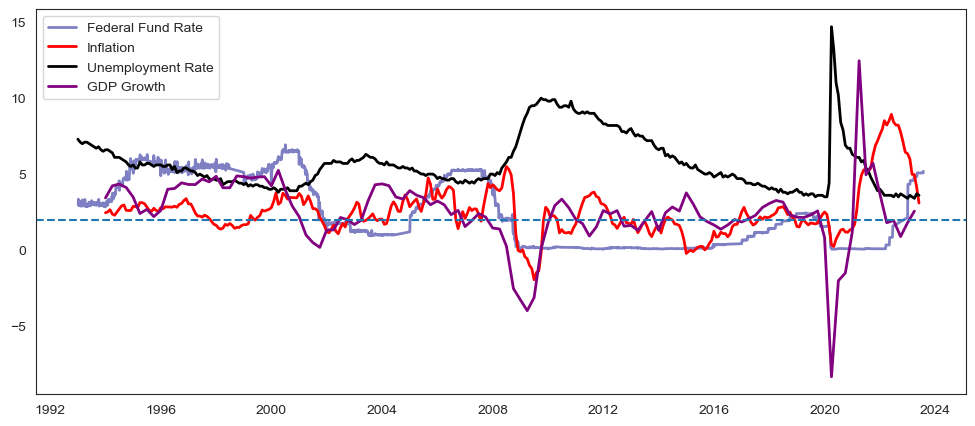

In [34]:
plt.figure(figsize=(12, 5))
plt.plot(fred['ffr'].dropna().rolling(5).mean(), color='darkblue', label='Federal Fund Rate', linewidth=2, alpha=.5)
plt.plot(fred['inflation_yoy'].dropna(), color='red', label='Inflation', linewidth=2)
plt.plot(fred['unemployment_rate'].dropna(), color='black', label='Unemployment Rate', linewidth=2)
plt.plot(fred['gdp_growth_yoy'].dropna(), color='purple', label='GDP Growth', linewidth=2)

plt.axhline(y=2, ls='dashed')
plt.legend()

<Axes: xlabel='date'>

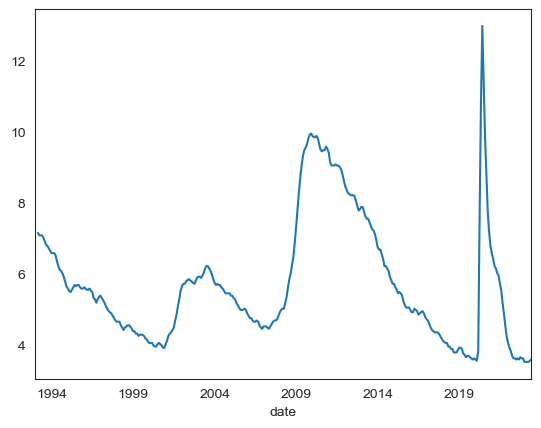

In [35]:
fred['unemployment_rate'].dropna().rolling(3).mean().plot()

### Topic Modeling

In [36]:
topics = pd.read_pickle('../data/fomc_topic_modeling.pkl').iloc[:, -6:]
topics.head()

topic 1  consumption  foreign_exchange_rate  inflation  \
1993-02-03  0.217142     0.222028               0.071233   0.354325   
1993-03-23  0.052435     0.337770               0.102628   0.422744   
1993-05-18  0.044406     0.325946               0.120336   0.428469   
1993-07-07  0.031498     0.281643               0.069809   0.522031   
1993-08-17  0.036917     0.411438               0.112277   0.312171   

            financial_market   topic 6  
1993-02-03          0.077838  0.057434  
1993-03-23          0.049573  0.034851  
1993-05-18          0.042354  0.038488  
1993-07-07          0.053767  0.041252  
1993-08-17          0.081001  0.046197

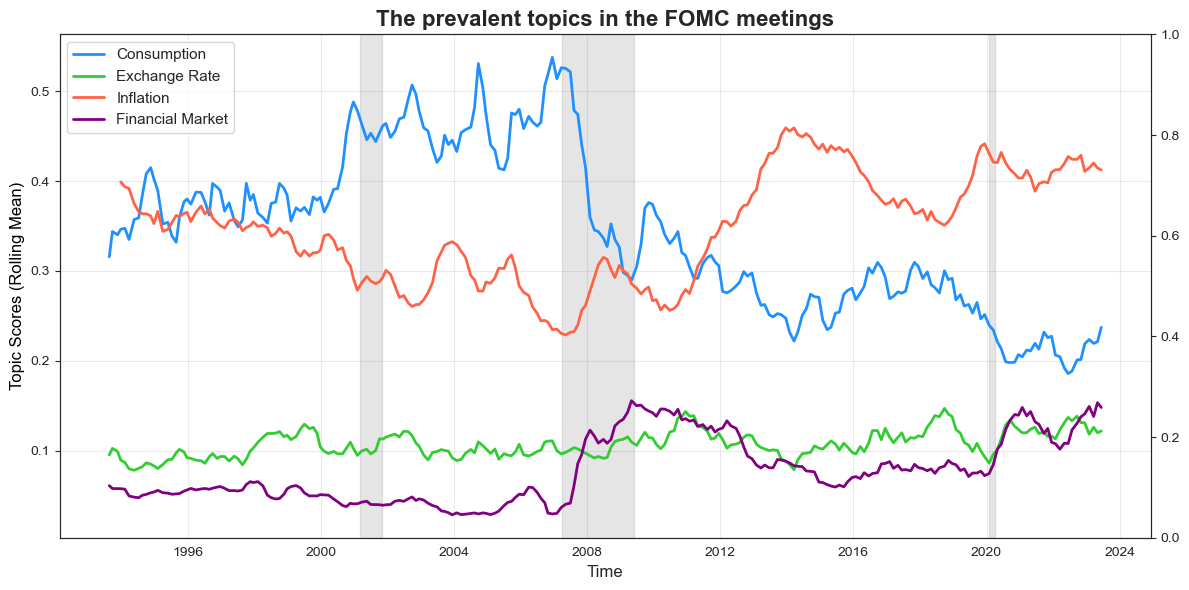

In [37]:
sns.set_style('white')

fig, ax0 = plt.subplots(figsize=(12, 6))
ax1 = ax0.twinx()

ax0.plot(topics['consumption'].rolling(5).mean(), label='Consumption', color='dodgerblue', linewidth=2)
ax0.plot(topics['foreign_exchange_rate'].rolling(5).mean(), label='Exchange Rate', color='limegreen', linewidth=2)
ax0.plot(topics['inflation'].rolling(8).mean(), label='Inflation', color='tomato', linewidth=2)
ax0.plot(topics['financial_market'].rolling(5).mean(), label='Financial Market', color='purple', linewidth=2)

# ax1.plot(fred['inflation'].dropna().rolling(5).mean(), label='Inflation Rate', 
#          color='black', linewidth=2, ls='dotted')

ax0.set_xlabel('Time', fontsize=12)
ax0.set_ylabel('Topic Scores (Rolling Mean)', color='black', fontsize=12)
# ax1.set_ylabel('Inflation Rate (Rolling Mean)', color='black', fontsize=12)

lines0, labels0 = ax0.get_legend_handles_labels()
lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines0 + lines1, labels0 + labels1, loc='upper left', fontsize=11)

ax0.axvspan(date_range01_start, date_range01_end, alpha=0.2, color='grey')
ax0.axvspan(date_range07_start, date_range07_end, alpha=0.2, color='grey')
ax0.axvspan(date_range20_start, date_range20_end, alpha=0.2, color='grey')

ax0.grid(alpha=0.4)

plt.title('The prevalent topics in the FOMC meetings', fontsize=16, fontweight='bold')

plt.tight_layout();
plt.savefig('../images/topics.png', dpi=600)

### Sentiment Analysis

In [38]:
sentiment_mc = pd.read_pickle('../data/fomc_raw_laughran_mcdonald_sentiment.pkl')
sentiment_zstc = pd.read_pickle('../data/fomc_raw_zstc_sentiment.pkl')

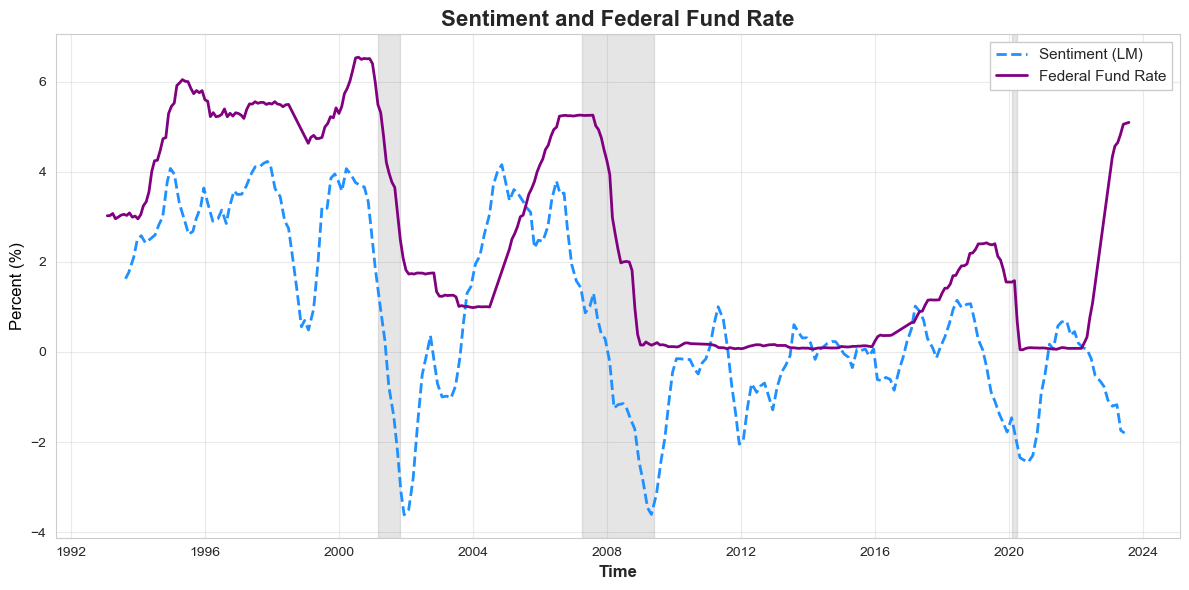

In [39]:
sns.set_style('whitegrid')

plt.figure(figsize=(12, 6))

plt.plot(sentiment_mc['sentiment_mc'].rolling(5).mean(), 
         label='Sentiment (LM)', color='dodgerblue', linewidth=2, linestyle='dashed')

plt.plot(fred['ffr'].resample('M').mean().dropna(), 
         label='Federal Fund Rate', color='purple', linewidth=2)

plt.xlabel('Time', fontsize=12, fontweight='bold', fontname='Arial')
plt.ylabel('Percent (%)', color='black', fontsize=12, fontname='Arial')
plt.title('Sentiment and Federal Fund Rate', fontsize=16, fontweight='bold', fontname='Arial')

plt.axvspan(date_range01_start, date_range01_end, alpha=0.2, color='grey')
plt.axvspan(date_range07_start, date_range07_end, alpha=0.2, color='grey')
plt.axvspan(date_range20_start, date_range20_end, alpha=0.2, color='grey')

plt.grid(alpha=0.4)

plt.legend(loc='upper right', fontsize=11, framealpha=1.0, fancybox=False)

plt.tight_layout()
plt.savefig('../images/semtiment_mc.png', dpi=600);

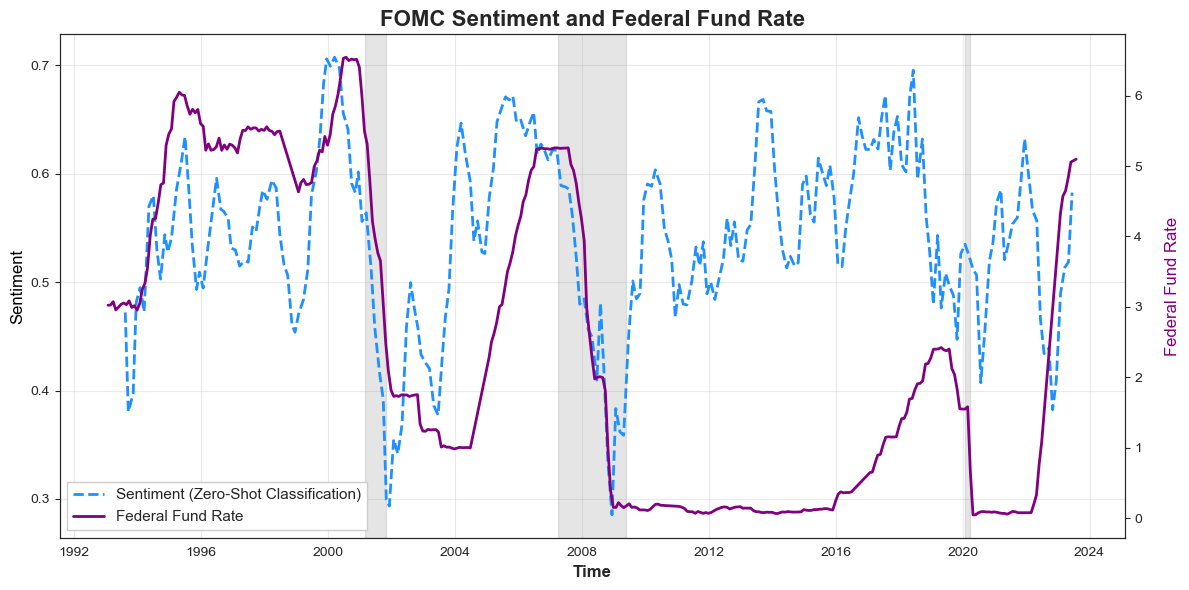

In [40]:
sns.set_style('white')

fig, ax0 = plt.subplots(figsize=(12, 6))
ax1 = ax0.twinx()

ax0.plot(sentiment_zstc['sentiment_zstc'].rolling(5).mean(), 
         label='Sentiment (Zero-Shot Classification)', color='dodgerblue', linewidth=2, linestyle='dashed')

ax1.plot(fred['ffr'].resample('M').mean().dropna(), 
         label='Federal Fund Rate', color='purple', linewidth=2)

ax0.set_xlabel('Time', fontsize=12, fontweight='bold', fontname='Arial')
ax0.set_ylabel('Sentiment', color='black', fontsize=12, fontname='Arial')
ax1.set_ylabel('\nFederal Fund Rate', color='purple', fontsize=12, fontname='Arial')

ax0.axvspan(date_range01_start, date_range01_end, alpha=0.2, color='grey')
ax0.axvspan(date_range07_start, date_range07_end, alpha=0.2, color='grey')
ax0.axvspan(date_range20_start, date_range20_end, alpha=0.2, color='grey')

ax0.grid(alpha=0.4)

plt.title('FOMC Sentiment and Federal Fund Rate', fontsize=16, fontweight='bold', fontname='Arial')

lines0, labels0 = ax0.get_legend_handles_labels()
lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines0 + lines1, labels0 + labels1, loc='lower left', fontsize=11, framealpha=1.0, fancybox=False)

plt.tight_layout()
plt.savefig('../images/semtiment_zstc.png', dpi=600);



#### Bollinger Bands

In [41]:
new = pd.DataFrame()
new['Adj Close'] = data['Adj Close']
new['close_std'] = data['Adj Close'].rolling(30).std()
new['close_ma30'] = data['Adj Close'].rolling(30).mean()
new['upper'] = new['close_ma30'] + 2*new['close_std']
new['lower'] = new['close_ma30'] - 2*new['close_std']

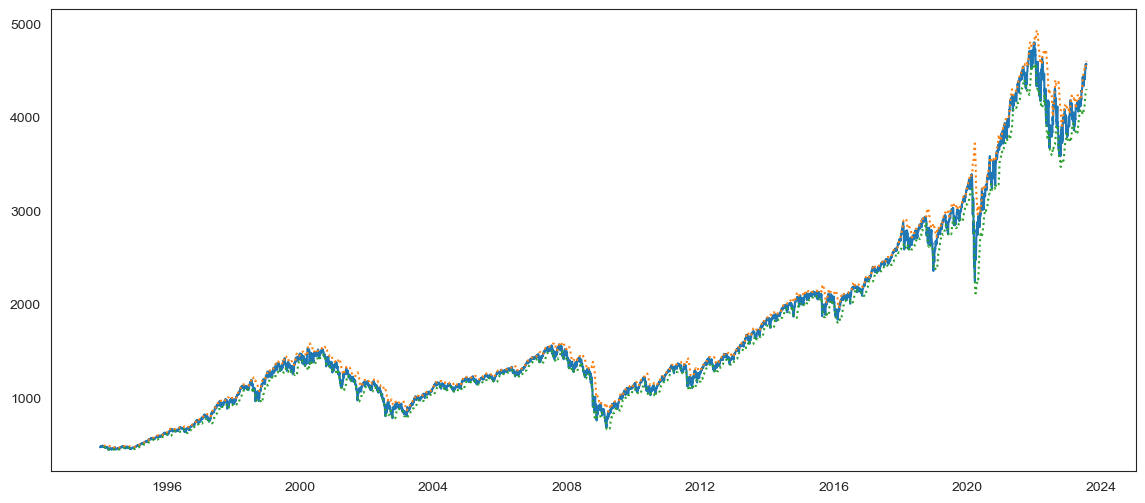

In [42]:
plt.figure(figsize=(14, 6))
plt.plot(new['Adj Close'])
plt.plot(new['upper'], ls='dotted')
plt.plot(new['lower'], ls='dotted')

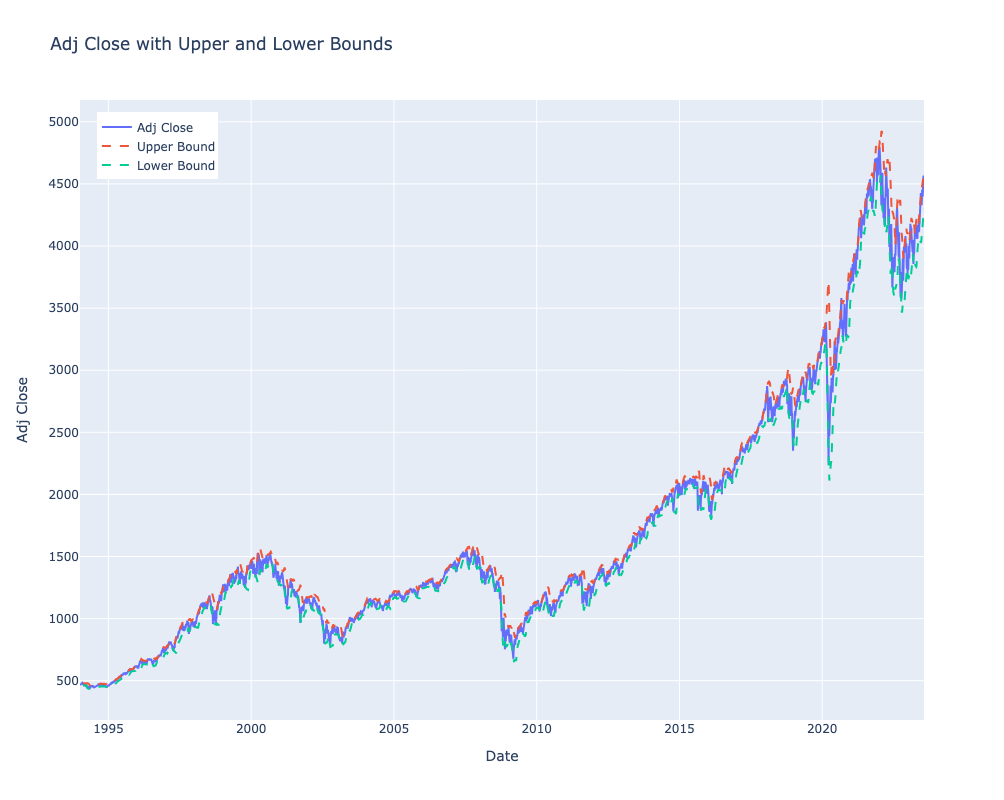

In [43]:
import plotly.graph_objects as go
sns.set_style('white')
fig = go.Figure()

fig.add_trace(go.Scatter(x=new.index, y=new['Adj Close'], mode='lines', name='Adj Close'))

fig.add_trace(go.Scatter(x=new.index, y=new['upper'], mode='lines', name='Upper Bound', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=new.index, y=new['lower'], mode='lines', name='Lower Bound', line=dict(dash='dash')))

fig.update_layout(
    title='Adj Close with Upper and Lower Bounds',
    xaxis_title='Date',
    yaxis_title='Adj Close',
    showlegend=True, 
    legend=dict(x=0.02, y=0.98),  
    height=800  
)

fig.show()